This notebook plots all placefield tuning curves to PDFs for inspection and calculates peaks and widths for each field.

It saves group placefield statistics as well.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
        plot_dir = Path('/data/Clustering/plots')
    else:  #BG computer
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
        sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

group_data_dir = Path('/data/Clustering/grpdata')

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
import pingouin as pg

from neuropy import plotting
from neuropy.core.epoch import Epoch
from neuropy.analyses.placefields import Pf1D, Pf1Dsplit
from neuropy.core.position import Position
from neuropy.plotting import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten

import subjects

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### Define sessions

In [2]:
ntrials_dict = {"RatUDay2": [25, 17], "RatVDay1": [23, 30], "RatVDay3": [163, 103],
                "RatSDay3": [23, 16], "RatUDay1": [54, 4], "RatUDay4": [32, 4],
                "RatVDay2": [79, 92], "RatRDay2": [41, 10]}
sessions = subjects.remaze_sess()[1:]  # RatSDay2NSD does not have remaze position info

### Load in group data

In [3]:
kw = dict(frate_thresh=0, grid_bin=5)  # Define placefield parameters
sigma2 = 1.5
height_thresh = 0.75
separate_run_dir = True

# Old, combined direction data with different speed and frate thresholds
# grp_savename = subjects.Group.basedir / f"placefield_stats.bin{kw['grid_bin']}.sigmabin{'_'.join(str(sigma2).split('.'))}.hthresh_{str(height_thresh).split('.')[1]}.csv"

run_flag = "run_dir_separate" if separate_run_dir == True else "run_dir_combined"
grp_savename = subjects.Group.basedir / f"placefield_grp_stats.bin{kw['grid_bin']}.sigmabin{'_'.join(str(sigma2).split('.'))}.hthresh_{str(height_thresh).split('.')[1]}_{run_flag}.csv"
stats_all_df = pd.read_csv(grp_savename, index_col=0)
stats_all_df

,cell_id,peak_no,height,prominence,center_bin,width_bin,left_edge,right_edge,r_odd_even,r_maze_remaze,FRmax,FRmax_other_session,direction,session,animal,day,grp,sid
0,7,0,3.0,3.0,45.358242,3.513363,43.486637,NaN,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0
1,7,1,0.7,0.5,35.953631,2.256332,34.801025,37.057357,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0
2,7,2,0.5,0.5,3.570236,3.626780,1.742038,5.368818,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0
3,9,0,0.3,0.3,28.592451,2.961924,27.175557,30.137481,NaN,0.012171,0.392076,4.165187,up,MAZE,RatU,Day2,NSD,0
4,9,1,0.3,0.3,44.586341,5.730577,41.269423,NaN,NaN,0.012171,0.392076,4.165187,up,MAZE,RatU,Day2,NSD,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204,55,5,1.1,1.1,59.000000,2.262388,57.868831,60.131219,0.641789,0.277849,3.793715,8.185448,down,reMAZE,RatR,Day2,SD,7
5205,55,6,0.4,0.4,67.000000,2.974970,65.512044,68.487014,0.641789,0.277849,3.793715,8.185448,down,reMAZE,RatR,Day2,SD,7
5206,59,0,0.7,0.7,51.000000,2.395026,49.802487,52.197513,NaN,0.392033,0.683997,0.377219,down,reMAZE,RatR,Day2,SD,7
5207,59,1,0.5,0.5,27.000000,2.793090,25.603455,28.396545,NaN,0.392033,0.683997,0.377219,down,reMAZE,RatR,Day2,SD,7


Bootstrap reliability and stability

In [16]:
stats_all_peak = stats_all_df[stats_all_df.peak_no == 0]
df_rs = stats_all_df.pivot_table(index=["grp", "sid", "cell_id"], 
                                 columns="session", 
                                 values="r_odd_even").reset_index().drop(columns="cell_id").reset_index()
df_rs.rename(columns={"sid": "session"})

session,index,grp,session,MAZE,reMAZE
0,0,NSD,0,-0.146584,0.784793
1,1,NSD,0,0.040590,NaN
2,2,NSD,0,0.688453,0.858604
3,3,NSD,0,0.363437,0.105582
4,4,NSD,0,0.988891,0.606790
...,...,...,...,...,...
439,439,SD,7,0.941697,0.313465
440,440,SD,7,0.511333,0.429512
441,441,SD,7,0.916543,0.699421
442,442,SD,7,0.492578,0.345600


### NRK TODO: rewrite lambda func to get nanmean for cells!

In [25]:
df_bs.head(30)

,grp,session,r_odd_even,metric,r_maze_remaze
0,NSD,MAZE,0.529078,r_odd_even,NaN
1,NSD,MAZE,0.597083,r_odd_even,NaN
2,NSD,MAZE,0.631673,r_odd_even,NaN
3,NSD,MAZE,0.603705,r_odd_even,NaN
4,NSD,MAZE,0.617347,r_odd_even,NaN
5,NSD,MAZE,0.549751,r_odd_even,NaN
6,NSD,MAZE,0.552545,r_odd_even,NaN
7,NSD,MAZE,0.579018,r_odd_even,NaN
8,NSD,MAZE,0.525365,r_odd_even,NaN
9,NSD,MAZE,0.636313,r_odd_even,NaN


In [24]:
from stats_utils import bootstrap_resample
func = lambda df: df.drop(["session"], axis=1).groupby(["grp"]).mean().reset_index()
df_bs_all = []
for metric in ["r_odd_even", "r_maze_remaze"]:
    print(metric)
    df_use = stats_all_df.pivot_table(index=["grp", "sid", "cell_id"], 
                                      columns="session", 
                                      values=metric).reset_index().drop(columns="cell_id").reset_index().rename(columns={"sid": "session"})
    df_bs = bootstrap_resample(df_use, level="both", n_iter=10, apply=func)
    df_bs = pd.melt(df_bs, id_vars=["grp"], value_vars=["MAZE", "reMAZE"], var_name="session", value_name=metric, ignore_index=False)
    df_bs["metric"] = metric
    df_bs_all.append(df_bs)

df_bs = pd.concat(df_bs_all, axis=0, ignore_index=False)
# df_bs.to_csv(group_data_dir / "remaze_fr_bootstrap.csv")
df_bs

r_odd_even
Running bootstraps for NSD group


100%|███████████████████████████████████████████████████████| 10/10 [00:00<00:00, 288.48it/s]


Running bootstraps for SD group


100%|███████████████████████████████████████████████████████| 10/10 [00:00<00:00, 243.07it/s]


r_maze_remaze
Running bootstraps for NSD group


100%|███████████████████████████████████████████████████████| 10/10 [00:00<00:00, 321.74it/s]


Running bootstraps for SD group


100%|███████████████████████████████████████████████████████| 10/10 [00:00<00:00, 254.81it/s]


,grp,session,r_odd_even,metric,r_maze_remaze
0,NSD,MAZE,0.529078,r_odd_even,NaN
1,NSD,MAZE,0.597083,r_odd_even,NaN
2,NSD,MAZE,0.631673,r_odd_even,NaN
3,NSD,MAZE,0.603705,r_odd_even,NaN
4,NSD,MAZE,0.617347,r_odd_even,NaN
...,...,...,...,...,...
15,SD,reMAZE,NaN,r_maze_remaze,0.243127
16,SD,reMAZE,NaN,r_maze_remaze,0.298248
17,SD,reMAZE,NaN,r_maze_remaze,0.176332
18,SD,reMAZE,NaN,r_maze_remaze,0.253125


### Example code to analyze placefield peaks and widths

In [4]:
# Use this code to quickly load placefields and test out things
sess = sessions[7]  # Session 7 has lowest number of neurons

maze = sess.paradigm["maze"].flatten()  # Grab times when rat was on the maze (as opposed to pre/post sleep recordings)
remaze = sess.paradigm["re-maze"].flatten()
neurons = sess.neurons_stable.get_neuron_type("pyr")  # get pre-selected stable neurons
kw = dict(frate_thresh=0, grid_bin=5)  # Define placefield parameters

pfmaze = Pf1D(neurons, position=sess.maze, **kw)
pfremaze = Pf1D(neurons, position=sess.remaze, **kw)

# Use this to test with first 5 placefield
# pf_maze_data_df = pfmaze.neuron_slice(inds=np.arange(5)).get_pf_data(step=0.1, height_thresh=0.75, plot=False)
# pf_remaze_data_df = pfremaze.neuron_slice(inds=np.arange(5)).get_pf_data(step=0.1, height_thresh=0.75, plot=False)

# Grab all fields here
pf_maze_data_df = pfmaze.get_pf_data(step=0.1, height_thresh=0.75, plot=False)
pf_remaze_data_df = pfremaze.get_pf_data(step=0.1, height_thresh=0.75, plot=False)

100%|███████████████████████████████████████████████████████████████████| 30/30 [00:10<00:00,  2.78it/s]


### Evaluate placefield reliability
- easiest - calculate correlation between tuning curves calculated from odd vs even minutes for each cell

#### PF corrs

##### First plot all without thresholding anything

In [7]:
# Create combined colormap, use cmap3[0::2] to plot dark colors and cmap[1::2] to plot same colors but in light / pastel
cmap1 = sns.color_palette(as_cmap=True)
cmap2 = sns.color_palette("pastel", as_cmap=True)
cmap3 = []
for c1, c2 in zip(cmap1, cmap2):
    cmap3.extend([c1, c2])

# cmap3

In [22]:
stats_all_df

,cell_id,peak_no,height,prominence,center_bin,width_bin,left_edge,right_edge,r_odd_even,r_maze_remaze,FRmax,FRmax_other_session,direction,session,animal,day,grp,sid
0,7,0,3.0,3.0,45.358242,3.513363,43.486637,NaN,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0
1,7,1,0.7,0.5,35.953631,2.256332,34.801025,37.057357,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0
2,7,2,0.5,0.5,3.570236,3.626780,1.742038,5.368818,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0
3,9,0,0.3,0.3,28.592451,2.961924,27.175557,30.137481,NaN,0.012171,0.392076,4.165187,up,MAZE,RatU,Day2,NSD,0
4,9,1,0.3,0.3,44.586341,5.730577,41.269423,NaN,NaN,0.012171,0.392076,4.165187,up,MAZE,RatU,Day2,NSD,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204,55,5,1.1,1.1,59.000000,2.262388,57.868831,60.131219,0.641789,0.277849,3.793715,8.185448,down,reMAZE,RatR,Day2,SD,7
5205,55,6,0.4,0.4,67.000000,2.974970,65.512044,68.487014,0.641789,0.277849,3.793715,8.185448,down,reMAZE,RatR,Day2,SD,7
5206,59,0,0.7,0.7,51.000000,2.395026,49.802487,52.197513,NaN,0.392033,0.683997,0.377219,down,reMAZE,RatR,Day2,SD,7
5207,59,1,0.5,0.5,27.000000,2.793090,25.603455,28.396545,NaN,0.392033,0.683997,0.377219,down,reMAZE,RatR,Day2,SD,7


In [24]:
frate_thresh = 3
stasts_all_df = stats_all_df[((stats_all_df.FRmax > frate_thresh) & (stats_all_df.session == "MAZE")) | ((stats_all_df.FRmax_other_session > frate_thresh) & (stats_all_df.session == "reMAZE"))]

/tmp/ipykernel_2138747/1791853806.py:5: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.stripplot(data=corrs_df_mean[corrs_df_mean.session == "MAZE"], x="session", y="r_maze_remaze", hue="grp", dodge=True, ax=ax[0],
/tmp/ipykernel_2138747/1791853806.py:10: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "NSD"], y="r_odd_even", hue="session", dodge=True, ax=ax[1],
/tmp/ipykernel_2138747/1791853806.py:15: UserWarning: The palette list has more values (18) than needed (2), which may not be intended.
  sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "SD"], y="r_odd_even", hue="session", dodge=True, ax=ax[2],


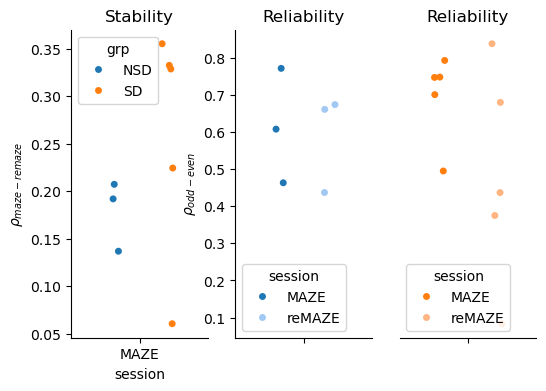

In [25]:
corrs_df_mean = stats_all_df.groupby(["grp", "animal", "day", "session"]).mean(numeric_only=True).reset_index()
corrs_df_mean

fig, ax = plt.subplots(1, 3, figsize=(6, 4))
sns.stripplot(data=corrs_df_mean[corrs_df_mean.session == "MAZE"], x="session", y="r_maze_remaze", hue="grp", dodge=True, ax=ax[0],
              palette=cmap1)
ax[0].set_title('Stability')
ax[0].set_ylabel(r"$\rho_{maze-remaze}$")

sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "NSD"], y="r_odd_even", hue="session", dodge=True, ax=ax[1],
              palette=cmap3)
ax[1].set_title('Reliability')
ax[1].set_ylabel(r"$\rho_{odd-even}$")

sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "SD"], y="r_odd_even", hue="session", dodge=True, ax=ax[2],
              palette=cmap3[2:])
ax[2].set_title('Reliability')

ymin = np.min([a.get_ylim()[0] for a in ax[1:]])
ymax = np.max([a.get_ylim()[1] for a in ax[1:]])
[a.set_ylim([ymin, ymax]) for a in ax[1:]];

sns.despine(fig=fig)
sns.despine(ax=ax[2], left=True)
ax[2].get_yaxis().set_visible(False)

/tmp/ipykernel_2138747/1779138230.py:7: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.violinplot(data=corrs_df[corrs_df.session == "MAZE"], y="r_maze_remaze", hue="grp", split=True, ax=ax[0],
/tmp/ipykernel_2138747/1779138230.py:12: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.violinplot(data=corrs_df[corrs_df.grp=="NSD"], y="r_odd_even", hue="session", split=True, cut=0, ax=ax[1],
/tmp/ipykernel_2138747/1779138230.py:17: UserWarning: The palette list has more values (18) than needed (2), which may not be intended.
  sns.violinplot(data=corrs_df[corrs_df.grp=="SD"], y="r_odd_even", hue="session", split=True, cut=0, ax=ax[2],
/tmp/ipykernel_2138747/1779138230.py:29: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.stripplot(data=corrs_df_mean[corrs_df_mean.session == "MAZE"], x="session", y="r_maze_remaze", hue="grp", dodge=Tr

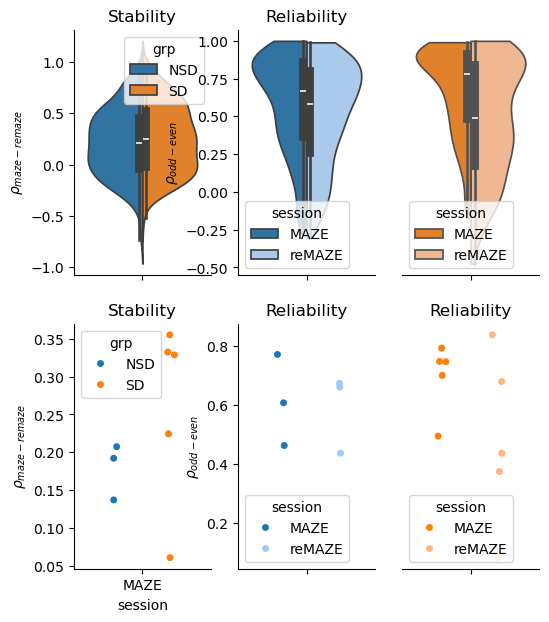

In [26]:
# Plot all data
corrs_df = stats_all_df.groupby(["grp", "animal", "day", "cell_id", "session"]).mean(numeric_only=True).reset_index()
corrs_df

fig, axs = plt.subplots(2, 3, figsize=(6, 7))
ax = axs[0]
sns.violinplot(data=corrs_df[corrs_df.session == "MAZE"], y="r_maze_remaze", hue="grp", split=True, ax=ax[0],
               palette=cmap1)
ax[0].set_title('Stability')
ax[0].set_ylabel(r"$\rho_{maze-remaze}$")

sns.violinplot(data=corrs_df[corrs_df.grp=="NSD"], y="r_odd_even", hue="session", split=True, cut=0, ax=ax[1],
               palette=cmap3)
ax[1].set_title('Reliability')
ax[1].set_ylabel(r"$\rho_{odd-even}$")

sns.violinplot(data=corrs_df[corrs_df.grp=="SD"], y="r_odd_even", hue="session", split=True, cut=0, ax=ax[2],
               palette=cmap3[2:])
# ax[2].set_title('Reliability')

ymin = np.min([a.get_ylim()[0] for a in ax[1:]])
ymax = np.max([a.get_ylim()[1] for a in ax[1:]])
[a.set_ylim([ymin, ymax]) for a in ax[1:]];

# Plot mean data by session
corrs_df_mean = stats_all_df.groupby(["grp", "animal", "day", "session"]).mean(numeric_only=True).reset_index()
ax = axs[1]

sns.stripplot(data=corrs_df_mean[corrs_df_mean.session == "MAZE"], x="session", y="r_maze_remaze", hue="grp", dodge=True, ax=ax[0],
              palette=cmap1)
ax[0].set_title('Stability')
ax[0].set_ylabel(r"$\rho_{maze-remaze}$")

sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "NSD"], y="r_odd_even", hue="session", dodge=True, ax=ax[1],
              palette=cmap3)
ax[1].set_title('Reliability')
ax[1].set_ylabel(r"$\rho_{odd-even}$")

sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "SD"], y="r_odd_even", hue="session", dodge=True, ax=ax[2],
              palette=cmap3[2:])
ax[2].set_title('Reliability')

ymin = np.min([a.get_ylim()[0] for a in ax[1:]])
ymax = np.max([a.get_ylim()[1] for a in ax[1:]])
[a.set_ylim([ymin, ymax]) for a in ax[1:]];

# Clean up
sns.despine(fig=fig)
for a2 in axs.T[2]:
    sns.despine(ax=a2, left=True)
    a2.get_yaxis().set_visible(False)


fig.savefig(plot_dir / f"SD_stability_reliability_{run_flag}.pdf")

### Run stats for above

In [27]:
from copy import deepcopy
def trim_unreliable_neurons(df_in):
    """Trims out neurons that aren't active in BOTH MAZE and reMAZE"""

    df_trim_comb = []
    for animal in df_in.animal.unique():
        df_animal = df_in[df_in.animal == animal]
        for day in df_animal.day.unique():
            df_use = df_animal[df_animal.day == day]
            maze_ids = df_use[df_use.session == "reMAZE"].cell_id.unique()
            remaze_ids = df_use[df_use.session == "MAZE"].cell_id.unique()
            maze_same = [np.isin(mid, remaze_ids) for mid in maze_ids]
            same_ids = maze_ids[maze_same]

            df_trim_temp = deepcopy(df_use)
            df_trim_comb.append(df_trim_temp[np.isin(df_trim_temp.cell_id, same_ids)])

    return pd.concat(df_trim_comb, axis=0, ignore_index=True)

df_use = trim_unreliable_neurons(corrs_df[corrs_df.grp == "NSD"])

In [28]:
# Stability
pg.mwu(x=corrs_df[corrs_df.grp == "NSD"].r_maze_remaze, y=corrs_df[corrs_df.grp == "SD"].r_maze_remaze)

,U-val,alternative,p-val,RBC,CLES
MWU,89037.0,two-sided,0.22264,0.047916,0.476042


In [29]:
df_use = trim_unreliable_neurons(corrs_df[corrs_df.grp == "SD"])
pg.wilcoxon(x=df_use[df_use.session == "MAZE"].r_odd_even, y=df_use[df_use.session == "reMAZE"].r_odd_even)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,3684.0,two-sided,1.259595e-12,0.593938,0.671717


In [30]:
df_use = trim_unreliable_neurons(corrs_df[corrs_df.grp == "NSD"])
pg.wilcoxon(x=df_use[df_use.session == "MAZE"].r_odd_even, y=df_use[df_use.session == "reMAZE"].r_odd_even)

,W-val,alternative,p-val,RBC,CLES
Wilcoxon,5771.0,two-sided,0.000021,0.357171,0.601243


In [33]:
df_sd = trim_unreliable_neurons(corrs_df[corrs_df.grp == "SD"])
df_nsd = trim_unreliable_neurons(corrs_df[corrs_df.grp == "NSD"])
pg.mwu(x=df_sd[df_sd.session == "MAZE"].r_odd_even, y=df_nsd[df_nsd.session == "MAZE"].r_odd_even)

,U-val,alternative,p-val,RBC,CLES
MWU,26154.0,two-sided,0.002568,-0.169521,0.584761


In [35]:
df_sd = trim_unreliable_neurons(corrs_df[corrs_df.grp == "SD"])
df_nsd = trim_unreliable_neurons(corrs_df[corrs_df.grp == "NSD"])
pg.mwu(x=df_sd[df_sd.session == "reMAZE"].r_odd_even, y=df_nsd[df_nsd.session == "reMAZE"].r_odd_even)

,U-val,alternative,p-val,RBC,CLES
MWU,18001.0,two-sided,0.757486,0.01827,0.490865


### Now plot for max firing rate

/tmp/ipykernel_2138747/2042741786.py:13: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.violinplot(data=corrs_df[corrs_df.grp=="NSD"], y=metric, hue="session", split=True, cut=0, ax=ax[1],
/tmp/ipykernel_2138747/2042741786.py:18: UserWarning: The palette list has more values (18) than needed (2), which may not be intended.
  sns.violinplot(data=corrs_df[corrs_df.grp=="SD"], y=metric, hue="session", split=True, cut=0, ax=ax[2],
/tmp/ipykernel_2138747/2042741786.py:35: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "NSD"], y=metric, hue="session", dodge=True, ax=ax[1],
/tmp/ipykernel_2138747/2042741786.py:40: UserWarning: The palette list has more values (18) than needed (2), which may not be intended.
  sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "SD"], y=metric, hue="session", dodge=True, ax=ax[2],


MWU signed-rank stats for NSD:
       U-val alternative     p-val      RBC     CLES
MWU  87668.0   two-sided  0.689146 -0.01604  0.50802


MWU signed-rank stats for SD:
       U-val alternative     p-val       RBC      CLES
MWU  72858.0   two-sided  0.000002  0.189169  0.405415




/tmp/ipykernel_2138747/2042741786.py:13: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.violinplot(data=corrs_df[corrs_df.grp=="NSD"], y=metric, hue="session", split=True, cut=0, ax=ax[1],
/tmp/ipykernel_2138747/2042741786.py:18: UserWarning: The palette list has more values (18) than needed (2), which may not be intended.
  sns.violinplot(data=corrs_df[corrs_df.grp=="SD"], y=metric, hue="session", split=True, cut=0, ax=ax[2],
/tmp/ipykernel_2138747/2042741786.py:35: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "NSD"], y=metric, hue="session", dodge=True, ax=ax[1],
/tmp/ipykernel_2138747/2042741786.py:40: UserWarning: The palette list has more values (18) than needed (2), which may not be intended.
  sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "SD"], y=metric, hue="session", dodge=True, ax=ax[2],


MWU signed-rank stats for NSD:
        U-val alternative         p-val      RBC     CLES
MWU  102964.0   two-sided  3.511974e-07 -0.20468  0.60234


MWU signed-rank stats for SD:
        U-val alternative         p-val       RBC      CLES
MWU  115052.0   two-sided  1.594972e-12 -0.280404  0.640202




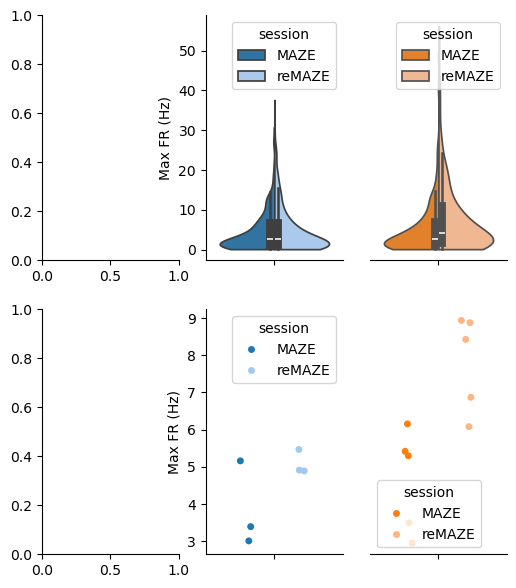

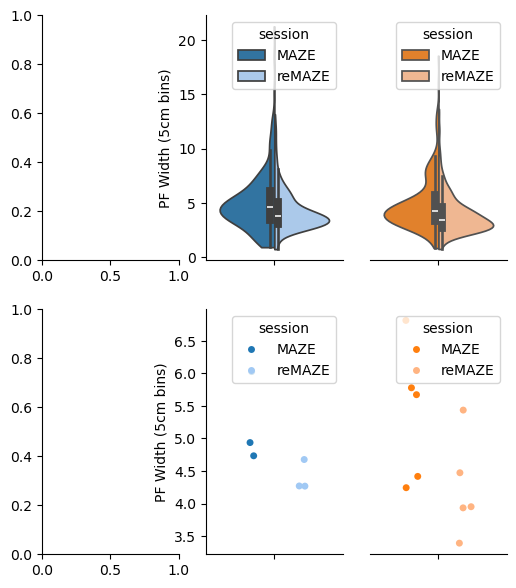

In [83]:
# Plot all data
# corrs_df = stats_all_df.groupby(["grp", "animal", "day", "cell_id", "session"]).mean(numeric_only=True).reset_index()
corrd_df = stats_all_df[stats_all_df.peak_no == 0].reset_index()  # for peak field only

for metric, mname in zip(["height", "width_bin"], ["Max FR (Hz)", "PF Width (5cm bins)"]):
    fig, axs = plt.subplots(2, 3, figsize=(6, 7))
    ax = axs[0]
    # sns.violinplot(data=corrs_df[corrs_df.session == "MAZE"], y="r_maze_remaze", hue="grp", split=True, ax=ax[0],
    #                palette=cmap1)
    # ax[0].set_title('Stability')
    # ax[0].set_ylabel(r"$\rho_{maze-remaze}$")
    
    sns.violinplot(data=corrs_df[corrs_df.grp=="NSD"], y=metric, hue="session", split=True, cut=0, ax=ax[1],
                   palette=cmap3)
    # ax[1].set_title('Reliability')
    ax[1].set_ylabel(mname)
    
    sns.violinplot(data=corrs_df[corrs_df.grp=="SD"], y=metric, hue="session", split=True, cut=0, ax=ax[2],
                   palette=cmap3[2:])
    # ax[2].set_title('Reliability')
    
    ymin = np.min([a.get_ylim()[0] for a in ax[1:]])
    ymax = np.max([a.get_ylim()[1] for a in ax[1:]])
    [a.set_ylim([ymin, ymax]) for a in ax[1:]];
    
    # Plot mean data by session
    corrs_df_mean = corrs_df.groupby(["grp", "animal", "day", "session"]).mean(numeric_only=True).reset_index()
    ax = axs[1]
    
    # sns.stripplot(data=corrs_df_mean[corrs_df_mean.session == "MAZE"], x="session", y="r_maze_remaze", hue="grp", dodge=True, ax=ax[0],
    #               palette=cmap1)
    # ax[0].set_title('Stability')
    # ax[0].set_ylabel(r"$\rho_{maze-remaze}$")
    
    sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "NSD"], y=metric, hue="session", dodge=True, ax=ax[1],
                  palette=cmap3)
    # ax[1].set_title('Reliability')
    ax[1].set_ylabel(mname)
    
    sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "SD"], y=metric, hue="session", dodge=True, ax=ax[2],
                  palette=cmap3[2:])
    # ax[2].set_title('Reliability')
    
    ymin = np.min([a.get_ylim()[0] for a in ax[1:]])
    ymax = np.max([a.get_ylim()[1] for a in ax[1:]])
    [a.set_ylim([ymin, ymax]) for a in ax[1:]];
    
    # Clean up
    sns.despine(fig=fig)
    for a2 in axs.T[2]:
        sns.despine(ax=a2, left=True)
        a2.get_yaxis().set_visible(False)

    for grp in ["NSD", "SD"]:
        print(f"MWU signed-rank stats for {grp}:")
        df_use = trim_unreliable_neurons(corrs_df[corrs_df.grp == grp])
        print(pg.mwu(x=df_use[df_use.session == "MAZE"][metric], y=df_use[df_use.session == "reMAZE"][metric]))
        print("\n")

    fig.savefig(plot_dir / f"SD_{metric}_{run_flag}.pdf")



/tmp/ipykernel_2138747/1507351834.py:12: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.violinplot(data=corrs_df[corrs_df.grp=="NSD"], y=metric, hue="session", split=True, cut=0, ax=ax[1],
/tmp/ipykernel_2138747/1507351834.py:17: UserWarning: The palette list has more values (18) than needed (2), which may not be intended.
  sns.violinplot(data=corrs_df[corrs_df.grp=="SD"], y=metric, hue="session", split=True, cut=0, ax=ax[2],
/tmp/ipykernel_2138747/1507351834.py:34: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "NSD"], y=metric, hue="session", dodge=True, ax=ax[1],
/tmp/ipykernel_2138747/1507351834.py:39: UserWarning: The palette list has more values (18) than needed (2), which may not be intended.
  sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "SD"], y=metric, hue="session", dodge=True, ax=ax[2],


Running un-paired test because not all cells have a second field in each session
Mann-Whitney U rank-sum stats for NSD:
       U-val alternative     p-val       RBC      CLES
MWU  52447.0   two-sided  0.069818 -0.084064  0.542032


Mann-Whitney U rank-sum stats for SD:
       U-val alternative     p-val      RBC     CLES
MWU  40855.0   two-sided  0.000758  0.15608  0.42196




/tmp/ipykernel_2138747/1507351834.py:12: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.violinplot(data=corrs_df[corrs_df.grp=="NSD"], y=metric, hue="session", split=True, cut=0, ax=ax[1],
/tmp/ipykernel_2138747/1507351834.py:17: UserWarning: The palette list has more values (18) than needed (2), which may not be intended.
  sns.violinplot(data=corrs_df[corrs_df.grp=="SD"], y=metric, hue="session", split=True, cut=0, ax=ax[2],
/tmp/ipykernel_2138747/1507351834.py:34: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "NSD"], y=metric, hue="session", dodge=True, ax=ax[1],
/tmp/ipykernel_2138747/1507351834.py:39: UserWarning: The palette list has more values (18) than needed (2), which may not be intended.
  sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "SD"], y=metric, hue="session", dodge=True, ax=ax[2],


Running un-paired test because not all cells have a second field in each session
Mann-Whitney U rank-sum stats for NSD:
       U-val alternative     p-val       RBC      CLES
MWU  53148.0   two-sided  0.000275 -0.171357  0.585679


Mann-Whitney U rank-sum stats for SD:
       U-val alternative         p-val       RBC     CLES
MWU  56742.0   two-sided  8.908263e-07 -0.230579  0.61529




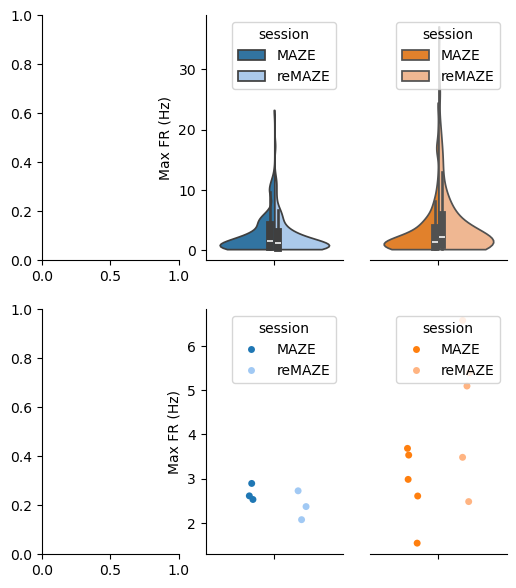

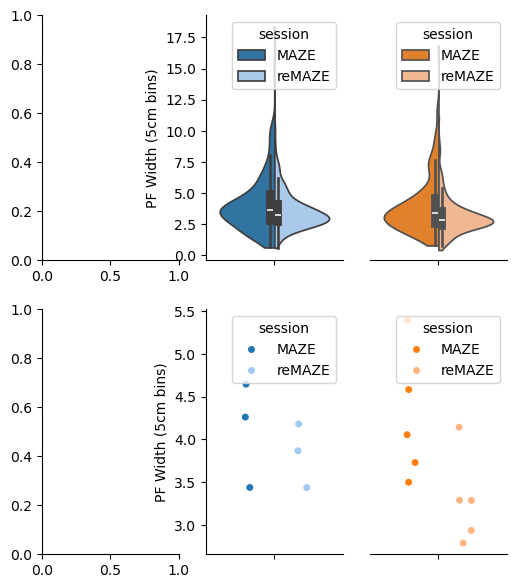

In [84]:
# Plot all data - 2nd peak only
corrs_df = stats_all_df[stats_all_df.peak_no == 1].reset_index()

for metric, mname in zip(["height", "width_bin"], ["Max FR (Hz)", "PF Width (5cm bins)"]):
    fig, axs = plt.subplots(2, 3, figsize=(6, 7))
    ax = axs[0]
    # sns.violinplot(data=corrs_df[corrs_df.session == "MAZE"], y="r_maze_remaze", hue="grp", split=True, ax=ax[0],
    #                palette=cmap1)
    # ax[0].set_title('Stability')
    # ax[0].set_ylabel(r"$\rho_{maze-remaze}$")
    
    sns.violinplot(data=corrs_df[corrs_df.grp=="NSD"], y=metric, hue="session", split=True, cut=0, ax=ax[1],
                   palette=cmap3)
    # ax[1].set_title('Reliability')
    ax[1].set_ylabel(mname)
    
    sns.violinplot(data=corrs_df[corrs_df.grp=="SD"], y=metric, hue="session", split=True, cut=0, ax=ax[2],
                   palette=cmap3[2:])
    # ax[2].set_title('Reliability')
    
    ymin = np.min([a.get_ylim()[0] for a in ax[1:]])
    ymax = np.max([a.get_ylim()[1] for a in ax[1:]])
    [a.set_ylim([ymin, ymax]) for a in ax[1:]];
    
    # Plot mean data by session
    corrs_df_mean = corrs_df.groupby(["grp", "animal", "day", "session"]).mean(numeric_only=True).reset_index()
    ax = axs[1]
    
    # sns.stripplot(data=corrs_df_mean[corrs_df_mean.session == "MAZE"], x="session", y="r_maze_remaze", hue="grp", dodge=True, ax=ax[0],
    #               palette=cmap1)
    # ax[0].set_title('Stability')
    # ax[0].set_ylabel(r"$\rho_{maze-remaze}$")
    
    sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "NSD"], y=metric, hue="session", dodge=True, ax=ax[1],
                  palette=cmap3)
    # ax[1].set_title('Reliability')
    ax[1].set_ylabel(mname)
    
    sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "SD"], y=metric, hue="session", dodge=True, ax=ax[2],
                  palette=cmap3[2:])
    # ax[2].set_title('Reliability')
    
    ymin = np.min([a.get_ylim()[0] for a in ax[1:]])
    ymax = np.max([a.get_ylim()[1] for a in ax[1:]])
    [a.set_ylim([ymin, ymax]) for a in ax[1:]];
    
    # Clean up
    sns.despine(fig=fig)
    for a2 in axs.T[2]:
        sns.despine(ax=a2, left=True)
        a2.get_yaxis().set_visible(False)

    print('Running un-paired test because not all cells have a second field in each session')
    for grp in ["NSD", "SD"]:
        print(f"Mann-Whitney U rank-sum stats for {grp}:")
        df_use = trim_unreliable_neurons(corrs_df[corrs_df.grp == grp])
        print(pg.mwu(x=df_use[df_use.session == "MAZE"][metric], y=df_use[df_use.session == "reMAZE"][metric]))
        print("\n")

    fig.savefig(plot_dir / f"SD_{metric}_2ndfield_{run_flag}.pdf")


/tmp/ipykernel_2138747/2532186571.py:14: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.violinplot(data=corrs_df[corrs_df.grp=="NSD"], y=metric, hue="session", split=True, cut=0, ax=ax[1],
/tmp/ipykernel_2138747/2532186571.py:19: UserWarning: The palette list has more values (18) than needed (2), which may not be intended.
  sns.violinplot(data=corrs_df[corrs_df.grp=="SD"], y=metric, hue="session", split=True, cut=0, ax=ax[2],
/tmp/ipykernel_2138747/2532186571.py:36: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "NSD"], y=metric, hue="session", dodge=True, ax=ax[1],
/tmp/ipykernel_2138747/2532186571.py:41: UserWarning: The palette list has more values (18) than needed (2), which may not be intended.
  sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "SD"], y=metric, hue="session", dodge=True, ax=ax[2],


Mann-Whitney U rank-sum stats for NSD:
      U-val alternative     p-val       RBC      CLES
MWU  2439.0   two-sided  0.803964 -0.022642  0.511321


Mann-Whitney U rank-sum stats for SD:
      U-val alternative     p-val       RBC      CLES
MWU  3499.0   two-sided  0.537952 -0.051382  0.525691




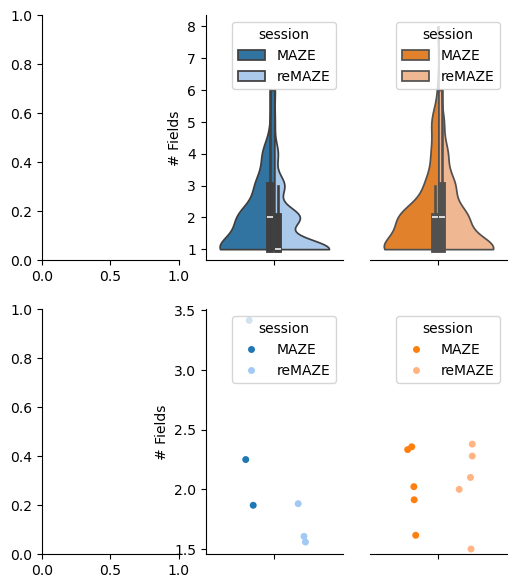

In [73]:
pf_stats_df_thresh = stats_all_df[stats_all_df.height > frate_thresh]
pf_num = pf_stats_df_thresh.drop(columns=["height", "prominence", "center_bin", "width_bin", "left_edge", "right_edge"]).groupby(["grp", "session", "sid", "direction", "cell_id"]).count().reset_index()
pf_num = pf_num.rename(columns={"peak_no": "n_fields"})
corrs_df = pf_num

for metric, mname in zip(["n_fields"], ["# Fields"]):
    fig, axs = plt.subplots(2, 3, figsize=(6, 7))
    ax = axs[0]
    # sns.violinplot(data=corrs_df[corrs_df.session == "MAZE"], y="r_maze_remaze", hue="grp", split=True, ax=ax[0],
    #                palette=cmap1)
    # ax[0].set_title('Stability')
    # ax[0].set_ylabel(r"$\rho_{maze-remaze}$")
    
    sns.violinplot(data=corrs_df[corrs_df.grp=="NSD"], y=metric, hue="session", split=True, cut=0, ax=ax[1],
                   palette=cmap3)
    # ax[1].set_title('Reliability')
    ax[1].set_ylabel(mname)
    
    sns.violinplot(data=corrs_df[corrs_df.grp=="SD"], y=metric, hue="session", split=True, cut=0, ax=ax[2],
                   palette=cmap3[2:])
    # ax[2].set_title('Reliability')
    
    ymin = np.min([a.get_ylim()[0] for a in ax[1:]])
    ymax = np.max([a.get_ylim()[1] for a in ax[1:]])
    [a.set_ylim([ymin, ymax]) for a in ax[1:]];
    
    # Plot mean data by session
    corrs_df_mean = corrs_df.groupby(["grp","session", "sid"]).mean(numeric_only=True).reset_index()
    ax = axs[1]
    
    # sns.stripplot(data=corrs_df_mean[corrs_df_mean.session == "MAZE"], x="session", y="r_maze_remaze", hue="grp", dodge=True, ax=ax[0],
    #               palette=cmap1)
    # ax[0].set_title('Stability')
    # ax[0].set_ylabel(r"$\rho_{maze-remaze}$")
    
    sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "NSD"], y=metric, hue="session", dodge=True, ax=ax[1],
                  palette=cmap3)
    # ax[1].set_title('Reliability')
    ax[1].set_ylabel(mname)
    
    sns.stripplot(data=corrs_df_mean[corrs_df_mean.grp == "SD"], y=metric, hue="session", dodge=True, ax=ax[2],
                  palette=cmap3[2:])
    # ax[2].set_title('Reliability')
    
    ymin = np.min([a.get_ylim()[0] for a in ax[1:]])
    ymax = np.max([a.get_ylim()[1] for a in ax[1:]])
    [a.set_ylim([ymin, ymax]) for a in ax[1:]];
    
    # Clean up
    sns.despine(fig=fig)
    for a2 in axs.T[2]:
        sns.despine(ax=a2, left=True)
        a2.get_yaxis().set_visible(False)

    for grp in ["NSD", "SD"]:
        print(f"Mann-Whitney U rank-sum stats for {grp}:")
        df_use = trim_unreliable_neurons(corrs_df[corrs_df.grp == grp])
        print(pg.mwu(x=df_use[df_use.session == "MAZE"][metric], y=df_use[df_use.session == "reMAZE"][metric]))
        print("\n")

    fig.savefig(plot_dir / f"SD_{metric}_{run_flag}.pdf")

## extraneous reliability and stability plots below

##### Now plot cells that meet firing rate threshold - note this is done by each track independently, so different cells could be included!

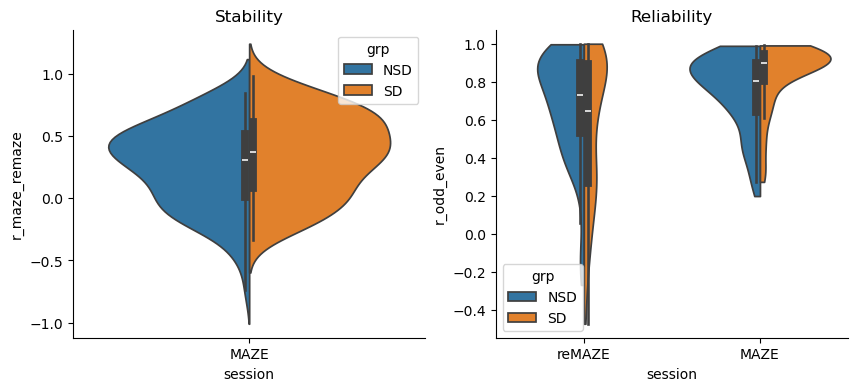

In [36]:
frate_thresh = 3  # From Wang, Monaco, Knierim 2020 (Curr. Bio)

# First, get rid of any cells without at least one field greater than frate_thresh (note these could be different cells from MAZE to reMAZE)
frate_thresh_df = stats_all_df[stats_all_df.height > frate_thresh]

corrs_df = frate_thresh_df.groupby(["grp", "animal", "day", "cell_id", "session"]).mean(numeric_only=True).reset_index()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.violinplot(data=corrs_df[corrs_df.session == "MAZE"], x="session", y="r_maze_remaze", hue="grp", split=True, ax=ax[0])
ax[0].set_title('Stability')

sns.violinplot(data=corrs_df, x="session", y="r_odd_even", hue="grp", dodge=True, split=True, cut=0, ax=ax[1])
ax[1].set_title('Reliability')

sns.despine(fig=fig)


In [16]:
# First reshape things to make your life easy
corrs_df_trim = corrs_df.drop(columns=["peak_no", "height", "prominence", "center_bin", "width_bin", "left_edge", "right_edge"])
corrs_df_rs = corrs_df_trim.pivot(index=["grp", "animal", "day", "cell_id"], columns="session", values=["r_odd_even", "r_maze_remaze"]).reset_index()
corrs_df_rs

grp animal   day cell_id r_odd_even           r_maze_remaze          
session                                 MAZE    reMAZE          MAZE    reMAZE
0        NSD   RatU  Day2       7   0.647907  0.499792     -0.223848 -0.223848
1        NSD   RatU  Day2      11   0.828705  0.976825      0.574304  0.574304
2        NSD   RatU  Day2      13   0.978270       NaN      0.957284       NaN
3        NSD   RatU  Day2      15   0.988319  0.922438      0.838046  0.838046
4        NSD   RatU  Day2      19   0.839446  0.802632      0.243575  0.243575
..       ...    ...   ...     ...        ...       ...           ...       ...
259       SD   RatV  Day2      70   0.989181       NaN      0.701623       NaN
260       SD   RatV  Day2      85   0.773420  0.722601      0.520954  0.520954
261       SD   RatV  Day2      86   0.928046  0.982102      0.870297  0.870297
262       SD   RatV  Day2      88        NaN  0.958972           NaN  0.248444
263       SD   RatV  Day2      97        NaN  0.949887           NaN  0.709306

[264 rows x 8 columns]

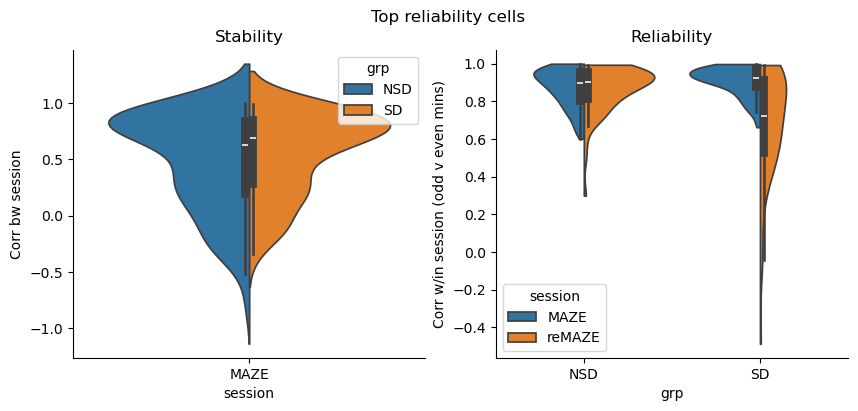

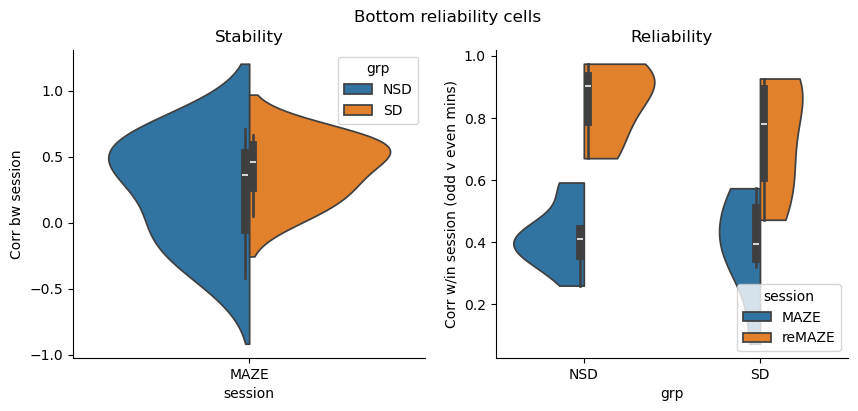

In [17]:
# Now plot top and bottom reliability cells...Very interesting, top cells get much less reliable in SD group, but bottom
# cells increase in reliability equally for both NSD and SD.
rel_thresh = 0.6  # eyeball to cut off bottom tail...

top_rel_df = corrs_df_rs[corrs_df_rs["r_odd_even"]["MAZE"] > rel_thresh]
top_rel_df = top_rel_df.melt(id_vars=["grp", "animal", "day", "cell_id"], var_name=["corr_type", "session"], value_name="Corr")
bot_rel_df = corrs_df_rs[corrs_df_rs["r_odd_even"]["MAZE"] < rel_thresh]
bot_rel_df = bot_rel_df.melt(id_vars=["grp", "animal", "day", "cell_id"], var_name=["corr_type", "session"], value_name="Corr")

for rel_df_use, cell_rel_grp in zip([top_rel_df, bot_rel_df], ["Top", "Bottom"]):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.violinplot(data=rel_df_use[(rel_df_use.session == "MAZE") & (rel_df_use.corr_type == "r_maze_remaze")], 
                   x="session", y="Corr", hue="grp", split=True, ax=ax[0])
    ax[0].set_title('Stability')
    ax[0].set_ylabel("Corr bw session")
    
    sns.violinplot(data=rel_df_use[rel_df_use.corr_type == "r_odd_even"], 
                   x="grp", y="Corr", hue="session", dodge=True, split=True, cut=0, ax=ax[1])
    ax[1].set_title('Reliability')
    ax[1].set_ylabel('Corr w/in session (odd v even mins)')
    fig.suptitle(f"{cell_rel_grp} reliability cells")
    
    sns.despine(fig=fig)


In [9]:
# Is the above driven by one session in SD? No, all but one session has a big drop, whereas NSD sessions only exhibit small drops.
top_rel_df[ (top_rel_df.corr_type == "r_odd_even")].drop(columns="cell_id").groupby(["grp", "animal", "day", "corr_type", "session"]).mean()

Corr
grp animal day  corr_type  session          
NSD RatU   Day2 r_odd_even MAZE     0.856988
                           reMAZE   0.800658
    RatV   Day1 r_odd_even MAZE     0.815312
                           reMAZE   0.792132
           Day3 r_odd_even MAZE     0.918244
                           reMAZE   0.910777
SD  RatR   Day2 r_odd_even MAZE     0.862507
                           reMAZE   0.690383
    RatS   Day3 r_odd_even MAZE     0.889474
                           reMAZE   0.786597
    RatU   Day1 r_odd_even MAZE     0.879393
                           reMAZE   0.342306
           Day4 r_odd_even MAZE     0.890453
                           reMAZE   0.542784
    RatV   Day2 r_odd_even MAZE     0.924098
                           reMAZE   0.922818

### #Peaks between sessions
Generally weak effects, seems like SD might prevent pruning of multi-fields, but very small at best

In [163]:
# Generate unique cell id for each neuron
gen_unique_cell_id = lambda row : f"{row['animal'][3]}d{row['day'][3]}c{row['cell_id']}"
frate_thresh_df.loc[:, "uid"] = frate_thresh_df.apply(gen_unique_cell_id, axis=1)

# Now find which cells meet reliability thresh in MAZE session and only keep those
top_rel_uids = frate_thresh_df[(frate_thresh_df.r_odd_even > rel_thresh) & (frate_thresh_df.session == "MAZE")].uid.unique()
top_rel_bool = [uid in top_rel_uids for uid in frate_thresh_df.uid]
top_rel_df = frate_thresh_df.loc[np.array(top_rel_bool), :]
top_rel_df


/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_3691/3913899057.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frate_thresh_df.loc[:, "uid"] = frate_thresh_df.apply(gen_unique_cell_id, axis=1)


,cell_id,peak_no,height,prominence,center_bin,width_bin,left_edge,right_edge,r_odd_even,r_maze_remaze,session,animal,day,grp,uid
0,7,0,5.100088,5.100088,45.978354,2.081165,44.918835,NaN,0.647907,-0.223848,MAZE,RatU,Day2,NSD,Ud2c7
7,11,0,3.073383,3.073383,22.628496,7.891918,18.383315,26.275233,0.828705,0.574304,MAZE,RatU,Day2,NSD,Ud2c11
8,11,1,2.273383,2.200000,45.891968,4.159813,42.840187,NaN,0.828705,0.574304,MAZE,RatU,Day2,NSD,Ud2c11
9,11,2,1.873383,1.400000,0.179747,1.979318,NaN,1.979318,0.828705,0.574304,MAZE,RatU,Day2,NSD,Ud2c11
11,13,0,3.307003,3.307003,0.014523,1.093423,NaN,1.093423,0.978270,0.957284,MAZE,RatU,Day2,NSD,Ud2c13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508,52,2,5.922868,0.600000,45.549234,2.976955,44.235705,47.212660,0.233660,0.316352,reMAZE,RatR,Day2,SD,Rd2c52
2509,52,3,5.022868,0.300000,75.829514,2.042461,74.722674,76.765136,0.233660,0.316352,reMAZE,RatR,Day2,SD,Rd2c52
2510,52,4,3.822868,2.100000,31.992130,2.416865,30.786159,33.203024,0.233660,0.316352,reMAZE,RatR,Day2,SD,Rd2c52
2511,52,5,2.022868,1.900000,0.015629,2.075298,NaN,2.075298,0.233660,0.316352,reMAZE,RatR,Day2,SD,Rd2c52


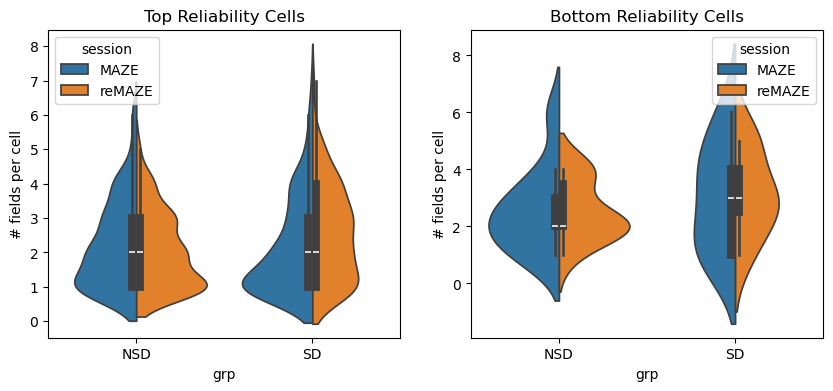

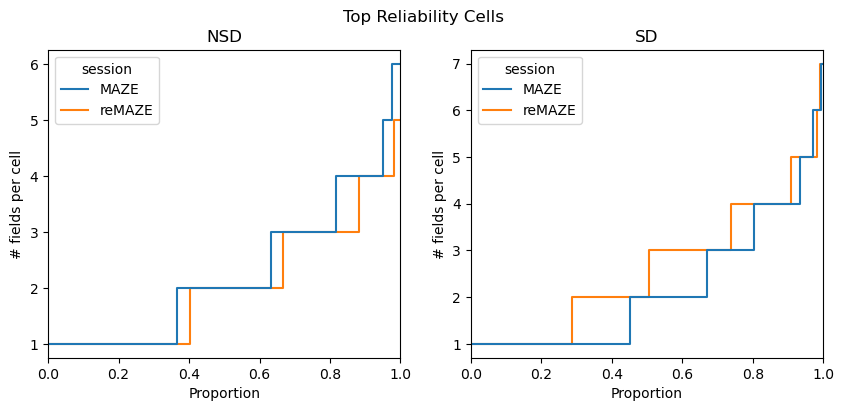

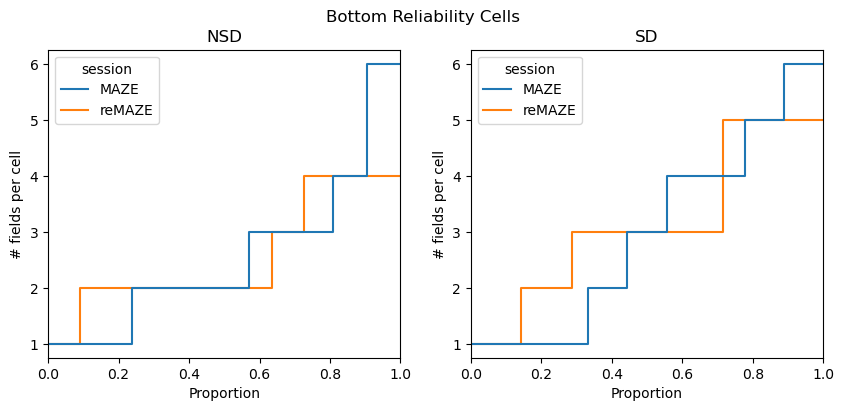

In [92]:
# Appears to be weak effect where there are fewer single-fielded cells in SD compared to NSD
drop_cols = ["peak_no", "height", "prominence", "center_bin", "width_bin", "left_edge", "right_edge", 
             "r_odd_even", "uid"]

# Filter which cells meet reliability thresh in MAZE session and only keep those
top_rel_uids = frate_thresh_df[(frate_thresh_df.r_odd_even > rel_thresh) & (frate_thresh_df.session == "MAZE")].uid.unique()
top_rel_bool = [uid in top_rel_uids for uid in frate_thresh_df.uid]
top_rel_df = frate_thresh_df.loc[np.array(top_rel_bool), :]
top_rel_count_df = top_rel_df.drop(columns=drop_cols).groupby(["grp", "animal", "day", "session", "cell_id"]).count().reset_index()

bot_rel_uids = frate_thresh_df[(frate_thresh_df.r_odd_even < rel_thresh) & (frate_thresh_df.session == "MAZE")].uid.unique()
bot_rel_bool = [uid in bot_rel_uids for uid in frate_thresh_df.uid]
bot_rel_df = frate_thresh_df.loc[np.array(bot_rel_bool), :]
bot_rel_count_df = bot_rel_df.drop(columns=drop_cols).groupby(["grp", "animal", "day", "session", "cell_id"]).count().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for a, rel_df_use, cell_rel_grp in zip(ax, [top_rel_count_df, bot_rel_count_df], ["Top", "Bottom"]):

    sns.violinplot(data=rel_df_use, x="grp", y="r_maze_remaze", hue="session", split=True, ax=a)
    a.set_ylabel("# fields per cell")
    a.set_title(f"{cell_rel_grp} Reliability Cells")

for rel_df_use, cell_rel_grp in zip([top_rel_count_df, bot_rel_count_df], ["Top", "Bottom"]):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f"{cell_rel_grp} Reliability Cells")
    for a, grp in zip(ax, ["NSD", "SD"]):
        sns.ecdfplot(data=rel_df_use[rel_df_use.grp == grp], y="r_maze_remaze", hue="session", ax=a)
        a.set_ylabel("# fields per cell")
        a.set_title(grp)

In [93]:
top_rel_count_df

,grp,animal,day,session,cell_id,r_maze_remaze
0,NSD,RatU,Day2,MAZE,7,1
1,NSD,RatU,Day2,MAZE,11,3
2,NSD,RatU,Day2,MAZE,13,1
3,NSD,RatU,Day2,MAZE,15,3
4,NSD,RatU,Day2,MAZE,19,4
...,...,...,...,...,...,...
465,SD,RatV,Day2,reMAZE,62,5
466,SD,RatV,Day2,reMAZE,64,3
467,SD,RatV,Day2,reMAZE,68,5
468,SD,RatV,Day2,reMAZE,85,2


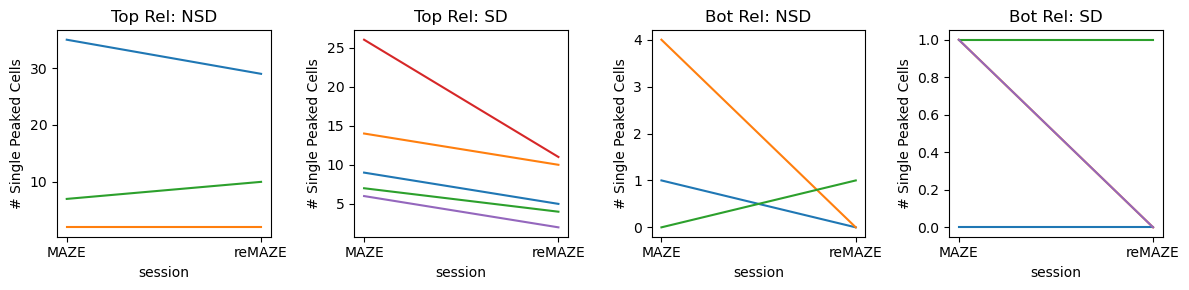

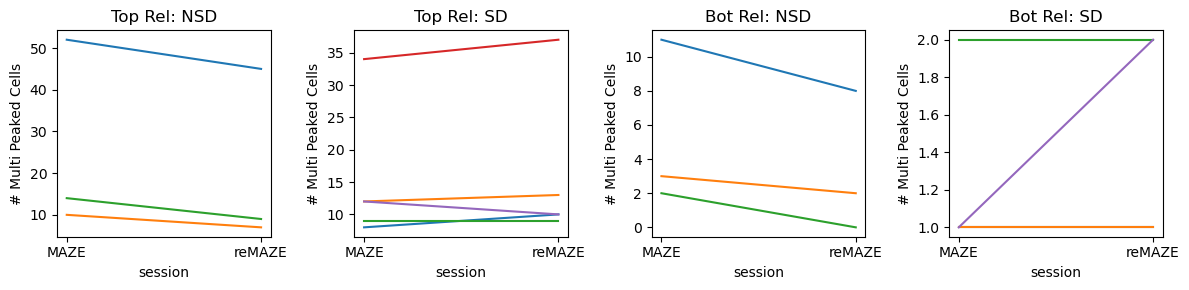

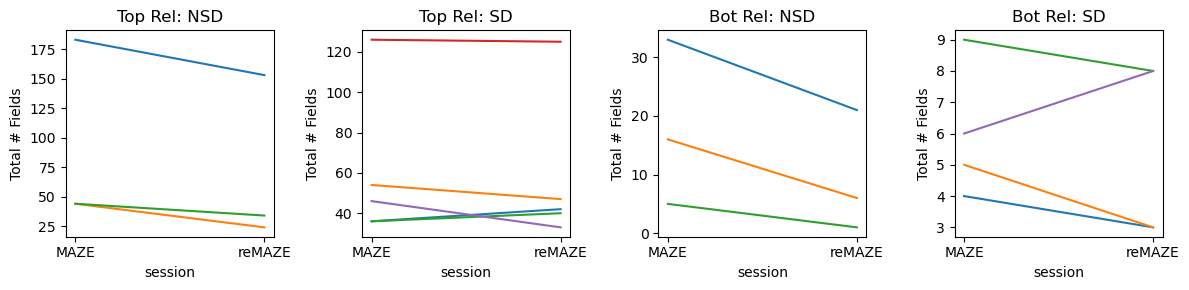

In [121]:
# It looks like there is a drop by session in single peaked cells for SD, and decrease in multi-peaked cells for NSD
multi_peaked = lambda row: row["r_maze_remaze"] > 1
top_rel_count_df.loc[:, "sesh_id"] = top_rel_count_df.apply(lambda row: f"{row['animal']}{row['day']}", axis=1)
top_rel_count_df.loc[:, "multi_peak"] = top_rel_count_df.apply(multi_peaked, axis=1)
top_rel_count_df.loc[:, "single_peak"] = top_rel_count_df["multi_peak"] == False

bot_rel_count_df.loc[:, "sesh_id"] = bot_rel_count_df.apply(lambda row: f"{row['animal']}{row['day']}", axis=1)
bot_rel_count_df.loc[:, "multi_peak"] = bot_rel_count_df.apply(multi_peaked, axis=1)
bot_rel_count_df.loc[:, "single_peak"] = bot_rel_count_df["multi_peak"] == False

rel_count_use = top_rel_count_df
rel_count_use = rel_count_use.drop(columns=["cell_id", "animal", "day"]).groupby(["grp", "sesh_id", "session"]).sum().rename(columns={"r_maze_remaze": "n_fields_total"}).reset_index()

for metric, met_name in zip(["single_peak", "multi_peak", "n_fields_total"], 
                            ["# Single Peaked Cells", "# Multi Peaked Cells", "Total # Fields"]):
    fig, ax = plt.subplots(1, 4, figsize=(12, 3), layout='tight')
    for rel_count_df, rel_desig, ax in zip([top_rel_count_df, bot_rel_count_df], ["Top", "Bot"], ax.reshape(2, 2)):
        rel_count_use = rel_count_df.drop(columns=["cell_id", "animal", "day"]).groupby(["grp", "sesh_id", "session"]).sum().rename(columns={"r_maze_remaze": "n_fields_total"}).reset_index()
        
        for a, grp in zip(ax, ["NSD", "SD"]):
            sns.lineplot(data=rel_count_use[rel_count_use.grp == grp], x="session", y=metric, hue="sesh_id", color="b", legend=False, ax=a)
            a.set_title(f"{rel_desig} Rel: {grp}")
            a.set_ylabel(met_name)


### Next plot width of peak field and total width of all fields

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_3691/2049429607.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_rel_df.loc[:, "uid2"] = top_rel_df.apply(lambda row: f"{row['uid']}{row['session']}", axis=1)


<Axes: xlabel='grp', ylabel='width_bin'>

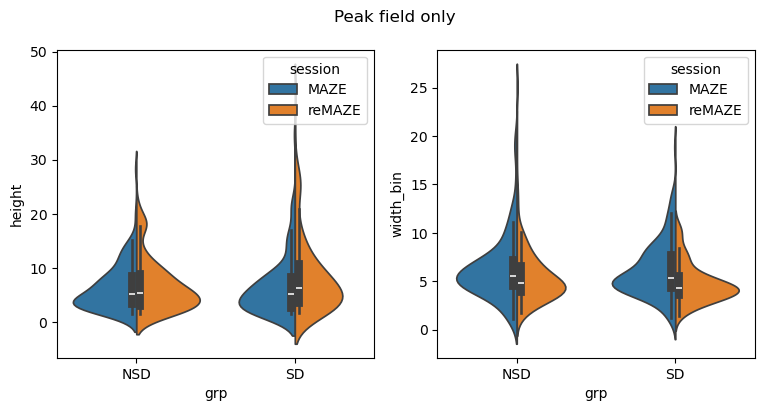

In [329]:
drop_cols = ["peak_no", "prominence", "left_edge", "right_edge", 
             "r_odd_even", "r_maze_remaze", "cell_id"]
top_rel_df.loc[:, "uid2"] = top_rel_df.apply(lambda row: f"{row['uid']}{row['session']}", axis=1)
df_use = top_rel_df.drop(columns=drop_cols)
df_peak, df_non_peak = [], []
for uid2 in df_use.uid2.unique():
    df_cell = df_use[df_use.uid2 == uid2]
    peak_ind = np.argmax(df_cell["height"])
    df_peak.append(pd.DataFrame(df_cell.iloc[peak_ind, :]).T)

    non_peak_inds = np.where(df_cell["height"] != np.max(df_cell["height"]))[0]
    df_non_peak.append(pd.DataFrame(df_cell.iloc[non_peak_inds, :]))

df_peak = pd.concat(df_peak, axis=0)
df_non_peak = pd.concat(df_non_peak, axis=0)

fig, ax = plt.subplots(1, 2, figsize=(9, 4))
fig.suptitle("Peak field only")
sns.violinplot(data=df_peak, x="grp", y="height", hue="session", split=True, ax=ax[0])
sns.violinplot(data=df_peak, x="grp", y="width_bin", hue="session", split=True, ax=ax[1])

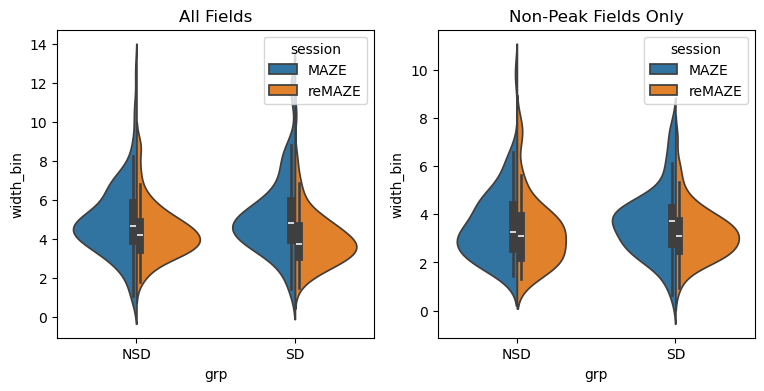

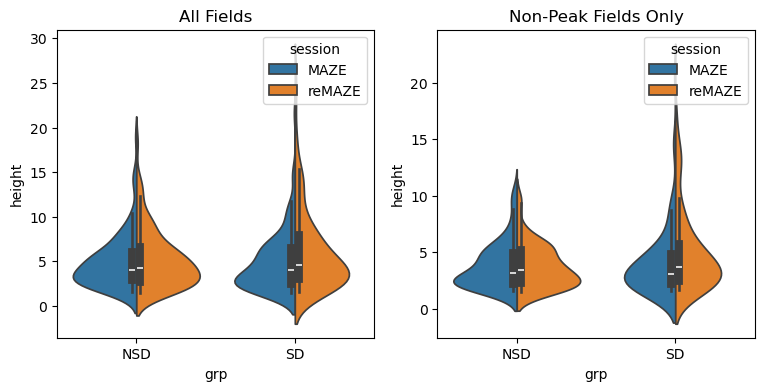

In [269]:
# Now plot mean width - weird, we see only a subtle increase in non-peak heights for NSD group, very subtle though

for metric in ["width_bin", "height"]:
    _, ax = plt.subplots(1, 2, figsize=(9, 4))
    for a, df_use, name in zip(ax, [top_rel_df.drop(columns=drop_cols), df_non_peak], ["All Fields", "Non-Peak Fields Only"]):
        rel_df_use = df_use.groupby(["grp", "animal", "session", "uid"]).mean(numeric_only=True).reset_index()
        sns.violinplot(data=rel_df_use, x="grp", y=metric, hue="session", split=True, ax=a)
        a.set_title(name)


#### Now plot ratio of next highest peak to highest peak - again very subtle difference
Also, 2ndary peak shows little change in width

<Axes: xlabel='grp', ylabel='center_diff'>

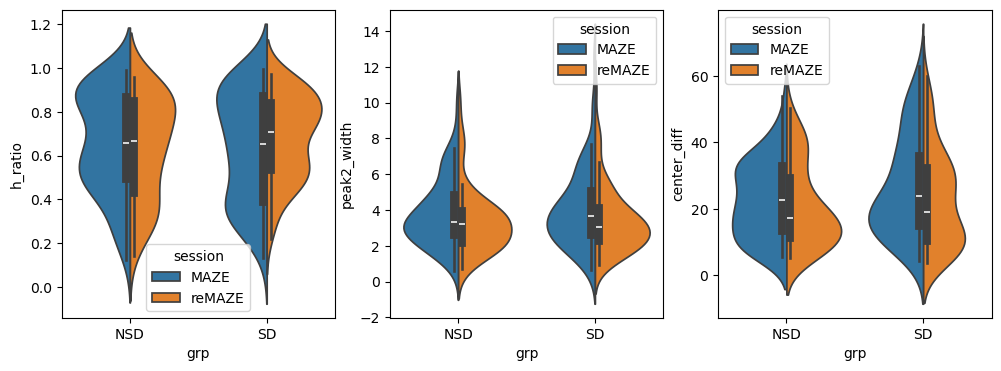

In [340]:
from copy import deepcopy
df_peak2 = deepcopy(df_peak)
df_peak_ratio = []

# Grab height of second peak
for uid2 in df_peak.uid2.unique():
    try:
        df_peak2.loc[df_peak2.uid2 == uid2, "peak2_height"] = df_non_peak[df_non_peak.uid2 == uid2]["height"].sort_values().values[-1]
    except IndexError:
        pass
    try:
        second_peak_ind = df_non_peak[df_non_peak.uid2 == uid2]["height"].argsort().values[-1]
        df_peak2.loc[df_peak2.uid2 == uid2, "peak2_width"] = df_non_peak[df_non_peak.uid2 == uid2]["width_bin"].values[0]
        df_peak2.loc[df_peak2.uid2 == uid2, "peak2_center"] = df_non_peak[df_non_peak.uid2 == uid2]["center_bin"].values[0]
    except IndexError:
        pass
df_peak2["h_ratio"] = df_peak2["peak2_height"] / df_peak2["height"]
df_peak2["center_diff"] = np.abs(df_peak2["center_bin"] - df_peak2["peak2_center"])

_, ax = plt.subplots(1, 3, figsize=(12, 4))
sns.violinplot(data=df_peak2, x="grp", y="h_ratio", hue="session", split=True, ax=ax[0])
sns.violinplot(data=df_peak2, x="grp", y="peak2_width", hue="session", split=True, ax=ax[1])
sns.violinplot(data=df_peak2, x="grp", y="center_diff", hue="session", split=True, ax=ax[2])

In [123]:
# Filter which cells meet reliability thresh in MAZE session and only keep those
top_rel_uids = frate_thresh_df[(frate_thresh_df.r_odd_even > rel_thresh) & (frate_thresh_df.session == "MAZE")].uid.unique()
top_rel_bool = [uid in top_rel_uids for uid in frate_thresh_df.uid]
top_rel_df = frate_thresh_df.loc[np.array(top_rel_bool), :]
top_rel_df

,cell_id,peak_no,height,prominence,center_bin,width_bin,left_edge,right_edge,r_odd_even,r_maze_remaze,session,animal,day,grp,uid
0,7,0,5.100088,5.100088,45.978354,2.081165,44.918835,NaN,0.647907,-0.223848,MAZE,RatU,Day2,NSD,Ud2c7
7,11,0,3.073383,3.073383,22.628496,7.891918,18.383315,26.275233,0.828705,0.574304,MAZE,RatU,Day2,NSD,Ud2c11
8,11,1,2.273383,2.200000,45.891968,4.159813,42.840187,NaN,0.828705,0.574304,MAZE,RatU,Day2,NSD,Ud2c11
9,11,2,1.873383,1.400000,0.179747,1.979318,NaN,1.979318,0.828705,0.574304,MAZE,RatU,Day2,NSD,Ud2c11
11,13,0,3.307003,3.307003,0.014523,1.093423,NaN,1.093423,0.978270,0.957284,MAZE,RatU,Day2,NSD,Ud2c13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508,52,2,5.922868,0.600000,45.549234,2.976955,44.235705,47.212660,0.233660,0.316352,reMAZE,RatR,Day2,SD,Rd2c52
2509,52,3,5.022868,0.300000,75.829514,2.042461,74.722674,76.765136,0.233660,0.316352,reMAZE,RatR,Day2,SD,Rd2c52
2510,52,4,3.822868,2.100000,31.992130,2.416865,30.786159,33.203024,0.233660,0.316352,reMAZE,RatR,Day2,SD,Rd2c52
2511,52,5,2.022868,1.900000,0.015629,2.075298,NaN,2.075298,0.233660,0.316352,reMAZE,RatR,Day2,SD,Rd2c52


In [335]:
df_peak2

,height,center_bin,width_bin,session,animal,day,grp,uid,sesh_id,uid2,peak2_height,peak2_width,peak2_center,h_ratio
0,5.100088,45.978354,2.081165,MAZE,RatU,Day2,NSD,Ud2c7,RatUDay2MAZE,Ud2c7MAZE,NaN,NaN,NaN,NaN
7,3.073383,22.628496,7.891918,MAZE,RatU,Day2,NSD,Ud2c11,RatUDay2MAZE,Ud2c11MAZE,2.273383,4.159813,45.891968,0.739701
11,3.307003,0.014523,1.093423,MAZE,RatU,Day2,NSD,Ud2c13,RatUDay2MAZE,Ud2c13MAZE,NaN,NaN,NaN,NaN
13,16.316252,8.502104,5.333319,MAZE,RatU,Day2,NSD,Ud2c15,RatUDay2MAZE,Ud2c15MAZE,5.116252,0.598098,0.040440,0.313568
19,6.594494,24.908239,10.51856,MAZE,RatU,Day2,NSD,Ud2c19,RatUDay2MAZE,Ud2c19MAZE,6.194494,1.478793,19.278130,0.939343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2469,8.501015,26.499145,8.690697,reMAZE,RatR,Day2,SD,Rd2c37,RatRDay2reMAZE,Rd2c37reMAZE,7.601015,1.287152,22.014315,0.89413
2475,8.8,82.15857,7.427378,reMAZE,RatR,Day2,SD,Rd2c38,RatRDay2reMAZE,Rd2c38reMAZE,7.300000,2.056738,75.864085,0.829545
2480,14.8,65.999914,4.041343,reMAZE,RatR,Day2,SD,Rd2c39,RatRDay2reMAZE,Rd2c39reMAZE,NaN,NaN,NaN,NaN
2501,5.332636,73.134507,4.651604,reMAZE,RatR,Day2,SD,Rd2c50,RatRDay2reMAZE,Rd2c50reMAZE,1.732636,4.000938,46.165465,0.324912


<Axes: xlabel='height', ylabel='Count'>

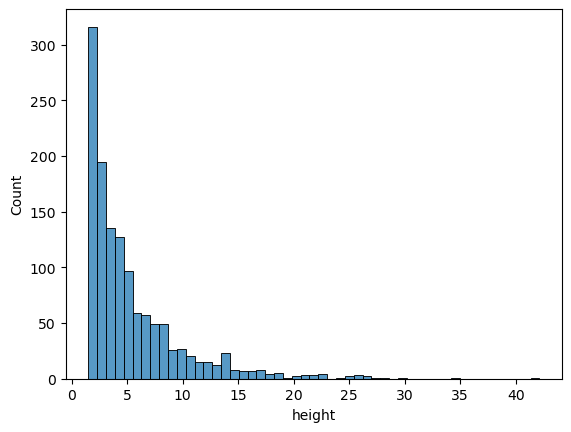

In [10]:
_, ax = plt.subplots()
sns.histplot(data=frate_thresh_df, x="height", ax=ax)